Auteur : Solenn Le Bivic  
Projet : Revenue Management – Prédiction d’annulation  
Technologies : Python, pandas, sklearn

# Prédiction du risque d’annulation – Machine Learning

## Objectif

L’objectif de cette section est de développer un modèle prédictif permettant d’estimer la probabilité d’annulation d’une réservation au moment où elle est effectuée.

Cette prédiction permettrait :

- D’anticiper le risque d’annulation
- D’adapter les conditions tarifaires (dépôt, flexibilité)
- De sécuriser le revenu
- D’améliorer la stabilité financière

Il ne s’agit pas ici de fixer un prix optimal, mais d’identifier les réservations à risque afin d’adapter la stratégie commerciale.

---

## Définition du problème

Type de problème : **Classification binaire**

Variable cible :
- `is_canceled`
  - 0 = Réservation maintenue
  - 1 = Réservation annulée

Moment de prédiction :
Le modèle utilise uniquement les informations disponibles au moment de la réservation.

Certaines variables postérieures à la réservation (ex : `reservation_status`) sont exclues afin d’éviter toute fuite d’information (data leakage).

---

## Préparation des données

Les étapes de préparation incluent :

- Séparation des variables explicatives (X) et de la cible (y)
- Suppression des variables à risque de fuite d’information
- Gestion des valeurs manquantes via imputation
- Encodage des variables catégorielles
- Séparation train/test

Un pipeline sklearn est utilisé afin de garantir un traitement cohérent et reproductible.

---

## Modèles testés

Plusieurs modèles sont comparés :

- Dummy Classifier (baseline)
- Logistic Regression (modèle interprétable)
- Random Forest (modèle non linéaire)

L’objectif est d’évaluer la capacité du modèle à identifier les réservations à risque.

---

## Métriques d’évaluation

Les métriques utilisées sont :

- ROC-AUC
- PR-AUC
- Recall (classe annulée)
- Matrice de confusion

Le rappel (recall) sur la classe "annulation" est particulièrement important dans une logique revenue management.

---

## Exploitation business

À partir des probabilités prédites, les réservations peuvent être classées en :

- Risque faible
- Risque moyen
- Risque élevé

Exemple d’application :

- Risque élevé → dépôt obligatoire / non-remboursable
- Risque moyen → conditions standard
- Risque faible → offre flexible

Ce modèle constitue un outil d’aide à la décision pour sécuriser le revenu.

---

## Limites

- Données historiques uniquement
- Absence d’informations sur la concurrence
- Pas de modélisation de l’élasticité prix
- Modèle basé uniquement sur les données internes

Une extension possible serait le développement d’un modèle de forecasting combiné à une optimisation tarifaire.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
csv_path = "hotel_bookings_cleaned.csv"
df = pd.read_csv(csv_path)

print("Shape:", df.shape)
df.head()

Shape: (118221, 39)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,reservation_status,reservation_status_date,arrival_date,revenue_net,month,season,is_weekend_stay,lead_bucket,total_nights,total_guests
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Check-Out,2015-07-01,2015-07-01,0.0,7,Summer,False,180+j,0,2.0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Check-Out,2015-07-01,2015-07-01,0.0,7,Summer,False,NaN,0,2.0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Check-Out,2015-07-02,2015-07-01,75.0,7,Summer,False,0-6j,1,1.0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Check-Out,2015-07-02,2015-07-01,75.0,7,Summer,False,7-29j,1,1.0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Check-Out,2015-07-03,2015-07-01,98.0,7,Summer,False,7-29j,2,2.0


In [3]:
TARGET = "is_canceled"

leakage_cols = [
    "reservation_status",
    "reservation_status_date",
    "assigned_room_type",
]

# On garde uniquement les colonnes existantes (sécurité)
leakage_cols = [c for c in leakage_cols if c in df.columns]

leakage_cols = [
    "reservation_status",
    "reservation_status_date",
    "assigned_room_type",
    "revenue_net"  # ← IMPORTANT
]

X = df.drop(columns=[TARGET] + leakage_cols)
y = df[TARGET].astype(int)

print("Dropped leakage cols:", leakage_cols)
print("X shape:", X.shape, "y mean cancel rate:", y.mean())

Dropped leakage cols: ['reservation_status', 'reservation_status_date', 'assigned_room_type', 'revenue_net']
X shape: (118221, 34) y mean cancel rate: 0.3704756346165233


In [4]:
# Split temporel

if "arrival_date_year" in df.columns:
    train_mask = df["arrival_date_year"] < 2017
    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[~train_mask], y[~train_mask]
    print("Temporal split:", X_train.shape, X_test.shape)
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print("Random split:", X_train.shape, X_test.shape)

Temporal split: (78284, 34) (39937, 34)


In [5]:
# Préprocessing (imputation + one-hot) via pipeline

num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ],
    remainder="drop"
)

print("Numeric cols:", len(num_cols), "| Categorical cols:", len(cat_cols))

Numeric cols: 21 | Categorical cols: 13


In [6]:
# Fonction d’évaluation (ROC-AUC / PR-AUC + matrices + courbes)

def evaluate_model(model, X_train, y_train, X_test, y_test, threshold=0.5, title="Model"):
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:, 1]
    pred = (proba >= threshold).astype(int)

    roc = roc_auc_score(y_test, proba)
    pr = average_precision_score(y_test, proba)

    print(f"\n=== {title} ===")
    print("ROC-AUC:", round(roc, 4))
    print("PR-AUC :", round(pr, 4))
    print("\nConfusion matrix:\n", confusion_matrix(y_test, pred))
    print("\nClassification report:\n", classification_report(y_test, pred, digits=3, zero_division=0))

    RocCurveDisplay.from_predictions(y_test, proba)
    plt.title(f"ROC Curve — {title}")
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_test, proba)
    plt.title(f"Precision-Recall Curve — {title}")
    plt.show()

    return proba


=== Dummy (Most Frequent) ===
ROC-AUC: 0.5
PR-AUC : 0.3868

Confusion matrix:
 [[24489     0]
 [15448     0]]

Classification report:
               precision    recall  f1-score   support

           0      0.613     1.000     0.760     24489
           1      0.000     0.000     0.000     15448

    accuracy                          0.613     39937
   macro avg      0.307     0.500     0.380     39937
weighted avg      0.376     0.613     0.466     39937



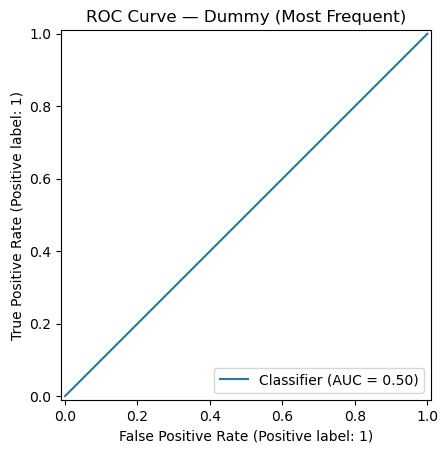

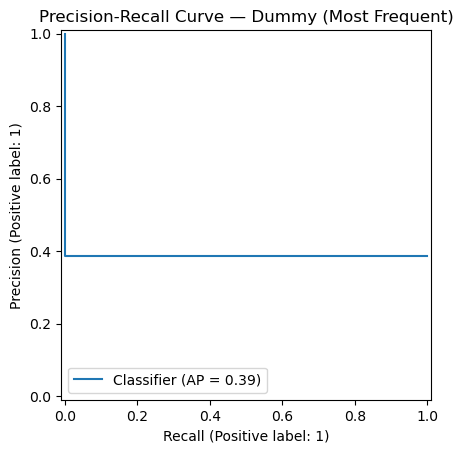

In [7]:
# Baseline (Dummy) + Logistic Regression + Random Forest

#Baseline (Dummy)

dummy = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DummyClassifier(strategy="most_frequent"))
])

_ = evaluate_model(dummy, X_train, y_train, X_test, y_test, title="Dummy (Most Frequent)")

## Modèle baseline

Un DummyClassifier est utilisé comme référence minimale.
Il prédit systématiquement la classe majoritaire.

Le modèle baseline montre qu’un modèle naïf ne permet pas d’identifier les annulations.

## Modèle 1 : Régression logistique

La régression logistique est un modèle **interprétable** :
elle fournit une base solide pour comprendre les facteurs associés au risque d’annulation.

- Les variables numériques sont standardisées (StandardScaler) pour améliorer la convergence.
- `class_weight="balanced"` aide à mieux gérer un éventuel déséquilibre de classes.


=== Logistic Regression ===
ROC-AUC: 0.861
PR-AUC : 0.8184

Confusion matrix:
 [[16134  8355]
 [ 2096 13352]]

Classification report:
               precision    recall  f1-score   support

           0      0.885     0.659     0.755     24489
           1      0.615     0.864     0.719     15448

    accuracy                          0.738     39937
   macro avg      0.750     0.762     0.737     39937
weighted avg      0.781     0.738     0.741     39937



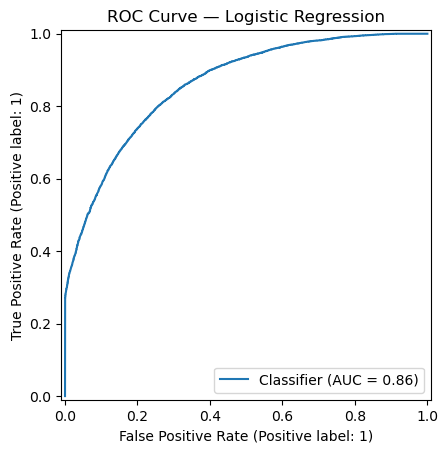

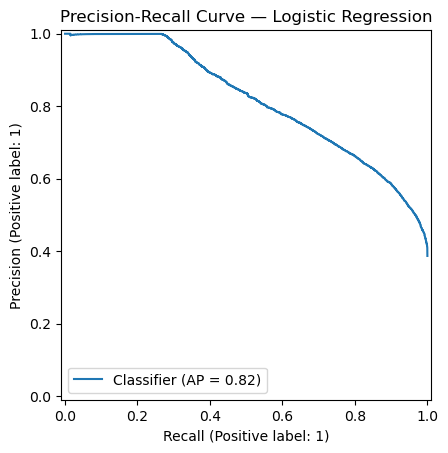

In [8]:
logreg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=5000, class_weight="balanced"))
])

proba_lr = evaluate_model(logreg, X_train, y_train, X_test, y_test, title="Logistic Regression")

Le modèle améliore significativement le ROC-AUC par rapport au baseline.
Il permet une meilleure discrimination entre réservations annulées et maintenues.

## Modèle 2 : Random Forest

Le Random Forest est un modèle non linéaire capable de capturer des interactions
complexes entre variables (ex : segment × lead time × dépôt).

Il est souvent performant sur des données tabulaires hétérogènes.


=== Random Forest ===
ROC-AUC: 0.8716
PR-AUC : 0.8256

Confusion matrix:
 [[22875  1614]
 [ 7268  8180]]

Classification report:
               precision    recall  f1-score   support

           0      0.759     0.934     0.837     24489
           1      0.835     0.530     0.648     15448

    accuracy                          0.778     39937
   macro avg      0.797     0.732     0.743     39937
weighted avg      0.788     0.778     0.764     39937



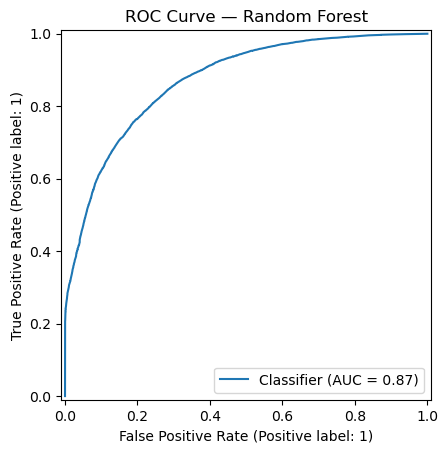

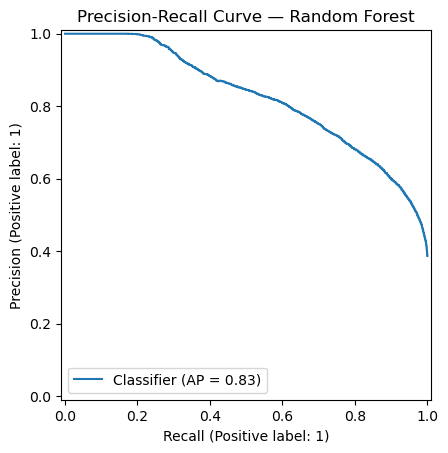

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

proba_rf = evaluate_model(rf, X_train, y_train, X_test, y_test, title="Random Forest")

## Comparaison des modèles

Pour synthétiser, je compare les métriques principales.
L’objectif est de sélectionner un modèle performant ET défendable métier.

In [10]:
scores = []

def quick_scores(name, y_true, proba):
    scores.append({
        "model": name,
        "roc_auc": roc_auc_score(y_true, proba),
        "pr_auc": average_precision_score(y_true, proba)
    })


quick_scores("Logistic Regression", y_test, proba_lr)
quick_scores("Random Forest", y_test, proba_rf)

pd.DataFrame(scores).sort_values(["pr_auc", "roc_auc"], ascending=False)

,model,roc_auc,pr_auc
1,Random Forest,0.871648,0.825636
0,Logistic Regression,0.861035,0.818448


### Sélection du modèle final

Le Random Forest présente une ROC-AUC de 0.87, légèrement supérieure à celle de la régression logistique.

Ce modèle est retenu comme modèle final en raison de sa meilleure capacité de discrimination.

Les performances obtenues sont cohérentes avec les résultats observés dans la littérature sur ce dataset.

## Exploitation business : score de risque d’annulation

L’objectif d’un modèle en Revenue Management n’est pas seulement de "prédire",
mais de **déclencher une action**.

Je transforme la probabilité d’annulation en 3 niveaux de risque :
- Faible
- Moyen
- Élevé

Et je propose une politique associée :
- Faible → Flexible
- Moyen → Standard
- Élevé → Dépôt / Non remboursable

> Les seuils (0.3 / 0.6) sont arbitraires ici et devraient être ajustés selon
les contraintes business (tolérance au risque, coût d'une annulation, etc.).

In [11]:
final_proba = proba_rf

results = X_test.copy()
results["cancel_proba"] = final_proba

results["risk_band"] = pd.cut(
    results["cancel_proba"],
    bins=[0, 0.3, 0.6, 1.0],
    labels=["Faible", "Moyen", "Élevé"]
)

results["policy_reco"] = results["risk_band"].map({
    "Faible": "Flexible",
    "Moyen": "Standard",
    "Élevé": "Dépôt / Non-remboursable"
})

results[["cancel_proba", "risk_band", "policy_reco"]].head(10)

,cancel_proba,risk_band,policy_reco
9666,0.363333,Moyen,Standard
9667,0.143333,Faible,Flexible
9668,0.143333,Faible,Flexible
9669,0.143333,Faible,Flexible
9670,0.593333,Moyen,Standard
9671,0.170000,Faible,Flexible
9672,0.206667,Faible,Flexible
9673,0.173333,Faible,Flexible
9674,0.200000,Faible,Flexible
9675,0.402804,Moyen,Standard


In [14]:
feature_names = (
    num_cols +
    list(rf.named_steps["preprocess"]
         .named_transformers_["cat"]
         .named_steps["onehot"]
         .get_feature_names_out(cat_cols))
)

importances = rf.named_steps["model"].feature_importances_

feat_imp = pd.Series(importances, index=feature_names)
feat_imp.sort_values(ascending=False).head(15)

country_PRT                    0.070217
lead_time                      0.066323
total_of_special_requests      0.052534
adr                            0.048889
deposit_type_Non Refund        0.047018
deposit_type_No Deposit        0.046210
agent                          0.033986
previous_cancellations         0.030929
arrival_date_day_of_month      0.026685
arrival_date_week_number       0.025188
total_nights                   0.023504
stays_in_week_nights           0.020747
required_car_parking_spaces    0.020192
booking_changes                0.018409
market_segment_Online TA       0.016491
dtype: float64

### Interprétation des variables importantes

Les variables les plus influentes selon le Random Forest sont :

- `country_PRT`
- `lead_time`
- `total_of_special_requests`
- `adr`
- `deposit_type`
- `previous_cancellations`

Le délai de réservation (`lead_time`) apparaît comme un facteur central : plus la réservation est effectuée en amont, plus le risque d’annulation augmente.

Le type de dépôt joue également un rôle structurant : les réservations sans dépôt présentent un risque plus élevé que celles assorties d’un dépôt non remboursable.

Le nombre de demandes spéciales et le niveau de tarif (`adr`) influencent aussi la probabilité d’annulation, ce qui suggère que le comportement client varie selon le profil et le niveau de service demandé.

Enfin, la variable pays (`country_PRT`) est fortement contributive. Cela peut refléter des comportements spécifiques liés à la clientèle domestique ou à des particularités du dataset.

## Limites du modèle

- Données historiques uniquement
- Pas d’informations concurrentielles
- Seuils de risque arbitraires (0.3 / 0.6)
- Modèle non intégré en temps réel

Ce modèle constitue une base exploratoire.
Un déploiement opérationnel nécessiterait
une validation supplémentaire et un suivi continu.

## Conclusion Machine Learning

Le modèle Random Forest permet d’identifier environ 53% des réservations effectivement annulées (recall = 0.53) avec une précision de 83%.

Cela signifie que lorsqu’il signale une réservation comme “à risque”, il a raison dans 83% des cas.

Ce compromis entre précision et rappel peut être ajusté selon la stratégie commerciale et la tolérance au risque de l’hôtel.